# Bayesian Optimization

Original version using GPyOpt and GPy was from Christian Forssen, TALENT Course 11, June, 2019, with extra documentation by Dick Furnstahl in November, 2019. This version was converted to scikit-learn in November, 2025 with the help of ChatGPT.

Selected references
* Paper: [Bayesian optimization in ab initio nuclear physics](https://iopscience.iop.org/article/10.1088/1361-6471/ab2b14) by A. Ekström, C. Forssén et al.,  J. Phys. G: Nucl. Part. Phys. 46, 095101 (2019).
* Book: Jonas Mockus (2012). Bayesian approach to global optimization: theory and applications. Kluwer Academic.
* Software: E.g., [GPyOpt](https://sheffieldml.github.io/GPyOpt/) from Sheffield ML. 
$  \newcommand{\thetavec}{\boldsymbol{\theta}} $

## Optimization of expensive objective functions

Let us first state an inconvenient fact about optimization:

> Global minimization is almost always intractable. In practice, we have to resort to local minimization:

$  \newcommand{\thetavec}{\boldsymbol{\theta}} $
For $f:\;\mathbf{R}^D \to \mathbf{R}$, with $\thetavec \in \Theta \subset \mathbf{R}^D$ and possibly subject to constraints $c(\thetavec) \leq 0$

Find point(s) $\thetavec_*$ for which

$$
f(\thetavec_*) \leq f(\thetavec),
$$

for all $\thetavec \in \Theta$ *close* to $\thetavec_*$. (Here $\thetavec$ are the parameters of the theoretical model.)

Nevertheless, we will often want to do the best we can toward global minimization.

$  \newcommand{\thetavec}{\boldsymbol{\theta}} $
Consider **expensive** objective functions, e.g.

$$
f(\theta) = \chi^2(\theta) \equiv \sum_{i=1}^N \frac{\left[ y_i^\mathrm{exp} - y_i^\mathrm{th}(\theta) \right]^2}{\sigma_i^2},
$$

where $y_i^\mathrm{th}(\theta)$ may be computationally costly to evaluate.  (The objective function is the function we want to minimize, such as a $\chi^2$ function.)  How shall we proceed?  Here we consider one strategy, Bayesian optimization, which has been used in the optimization of hyperparameters of deep neural networks.  It is not necessarily the best strategy (see comments at the end), but it is an option in our toolkit.

## Bayesian optimization

> An optimization algorithm for expensive black-box functions

Bayesian optimization provides a strategy for selecting a sequence of function queries.  This is an alternative to a gradient descent method, which relies on derivatives of the function to move toward a nearby local minimum.


This diagram from [Wikimedia Commons](https://creativecommons.org/licenses/by-sa/4.0) illustrates the sequential moves in Newton's method for finding a root, with a sequence of $x$ values: $x_0 \rightarrow x_1 \rightarrow x_2 \rightarrow \ldots$ that approach a nearby zero of the function.
<img width="256" alt="Newton method scheme" src="https://upload.wikimedia.org/wikipedia/commons/b/bb/Newton%E2%80%93Raphson_method.png">
If applied to the derivative of a function, this yields a sequential approximation to a local minimum or maximum. We seek a different way to construct this sequence.

There are two main components in the Bayesian optimization algorithm, which will each be contingent on what we call the data $\mathcal{D}$, which will be the previously evaluated pairs of $\theta$ and $f(\theta)$. 
1. A prior probabilistic pdf $p(f|\mathcal{D})$ for the objective function $f(\theta)$ given some data $\mathcal{D}$. The prior is often a Gaussian process (GP) or a GP emulator. This will be updated with every iteration. The GP acts as a *surrogate* for the actual objective function, which we can evaluate at any given $\theta$, but it is so expensive to do so that we don't know its structure a priori. The idea is that we will do Bayesian updating each iteration after confronting the surrogate model with actual data $f(\theta)$.  So we refine the posterior for $f$, which becomes the prior for the next iteration.
1. An acquisition function $\mathcal{A}(\theta|\mathcal{D})$ given some data $\mathcal{D}$. This is a heuristic that balances *exploration* against *exploitation* and determines where to evaluate the objective function $f(\theta)$ next. Explorative means that you evaluate points in a domain of $\theta$ where the prior pdf for $f$ has large uncertainty.  This enables the escape from local minima in $\theta$.  Exploitive means that you evaluate points in a domain of $\theta$ where the prior pdf for $f$ exhibits low mean values. (This zeroes in on a local minimum.) 

Pseudo-code for BayesOpt:
1. choose initial $\mathbf{\theta}^{(1)},\mathbf{\theta}^{(2)},\ldots \mathbf{\theta}^{(k)}$, where $k \geq 2$
1. evaluate the objective function $f(\mathbf{\theta})$ to obtain $y^{(i)}=f(\mathbf{\theta}^{(i)})$ for $i=1,\ldots,k$
1. initialize a data vector $\mathcal{D}_k = \left\{(\mathbf{\theta}^{(i)},y^{(i)})\right\}_{i=1}^k$
1. select a statistical model for $f(\mathbf{\theta})$ (for us some choice of GP kernel)
1. **for** {$n=k+1,k+2,\ldots$}
   1.    select $\mathbf{\theta}^{(n)}$ by optimizing (maximizing) the acquisition function
   1.    $\mathbf{\theta}^{(n)} = \underset{\mathbf{\theta}}{\text{arg max}}\, \mathcal{A}(\mathbf{\theta}|\mathcal{D}_{n-1})$
   1.    evaluate the objective function to obtain $y^{(n)}=f(\mathbf{\theta}^{(n)})$
   1.    augment the data vector $\mathcal{D}_n = \left\{\mathcal{D}_{n-1} , (\mathbf{\theta}^{(n)},y^{(n)})\right\}$
   1.    update the statistical model for $f(\mathbf{\theta})$
1. **end for**


Some remarks:
* Use a space-filling method such as LHS (Latin hypercube sampling) or Sobol (see references) for the initial $k$ evaluations.
* Use of a gaussian process, or a Gaussian emulator, for the statistical model of $f(\theta)$.
* The choice of aquisition function is the heart of BayesOpt. There are several possible choices; with different balance between exploration-exploitation.
   * Expected improvement
   * Lower confidence bound
* The update of the statistical model is an $\mathcal{O}(n^3)$ cost (if using a GP).
* At each iteration, *all* collected data points are used, thus we build on the full history of the optimization procedure.
* The stopping criterion might be a fixed computational budget that limits the number of function evaluations that can be made.

## Acquisition functions

We will consider two different acquisition functions:
* Expected Improvement (EI)
* Lower Confidence Bound (LCB)


Note that we abbreviate the notation below and write $\mathcal{A}(\mathbf{\theta}) \equiv \mathcal{A}(\mathbf{\theta}| D)$.

### Expected Improvement
The expected improvement acquisition function is defined by the
expectation value of the rectifier ${\rm max}(0,f_{\rm min} -
f(\mathbf{\theta}))$, i.e. we reward any expected reduction of $f$ in
proportion to the reduction $f_{\rm min} - f(\mathbf{\theta})$. This can be evaluated analytically

$$
\begin{align}
  \begin{split}
    \mathcal{A}_{\rm EI}({\mathbf{\theta}})=  \langle {\rm max}(0,f_{\rm min} - f(\mathbf{\theta})) \rangle &= \int_{-\infty}^{\infty} {\rm max}(0,f_{\rm min}-f)\mathcal{N}(f(\mathbf{\theta})|\mu(\mathbf{\theta}),\sigma(\mathbf{\theta})^2)\,\, df(\mathbf{\theta}) \\
           &= \int_{-\infty}^{f_{\rm min}} (f_{\rm min} - f) \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left[{-\frac{(f-\mu)^2}{2\sigma^2}}\right] \,\,df  \\
            &= (f_{\rm min} - \mu)\Phi\left(\frac{f_{\rm min} - \mu}{\sigma}\right) + \sigma \phi\left(\frac{f_{\rm min} - \mu}{\sigma}\right) \\
            &= \sigma \left( z \Phi(z) + \phi(z) \right),
  \end{split}  
\end{align}
$$


where

$$
\mathcal{N}(f(\mathbf{\theta})|\mu(\mathbf{\theta}),\sigma(\mathbf{\theta})^2)
$$

indicates the density function of the normal distribution, whereas the standard normal distribution and the cumulative
distribution function are denoted
$\phi$ and $\Phi$, respectively, and we dropped the explicit
dependence on $\mathbf{\theta}$ in the third step. 

In the last step we
write the result in the standard normal variable $z=\frac{f_{\rm
    min}-\mu}{\sigma}$. BayesOpt will exploit regions of expected
improvement when the term $z \Phi(z)$ dominates, while new, unknown
regions will be explored when the second term $\phi(z)$ dominates. For
the expected improvement acquisition function, the
exploration-exploitation balance is entirely determined by the set of
observed data $\mathcal{D}_n$ and the $\mathcal{GP}$ kernel.

Note 1: Density function of the normal distribution:
  $\mathcal{N}(\theta|\mu,\sigma^2) =
  \frac{1}{\sqrt{2\pi}\sigma}\exp\left(
  -\frac{1}{2\sigma^2}(\theta-\mu)^2\right)$ 
  
 Note 2: Density function of the *standard* normal distribution: $\phi(z) \equiv \mathcal{N}(z|\mu=0,\sigma^2=1) = \frac{1}{\sqrt{2 \pi}}\exp\left( -\frac{1}{2}z^2\right)$
 
 Note 3: Cumulative distribution function of the standard normal: $\Phi(z) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{z}\exp\left(-\frac{t^2}{2}\right)\, dt$

### Lower Confidence Bound
The lower confidence-bound acquisition function introduces an additional
parameter $\beta$ that explicitly sets the level of exploration

$$
  \mathcal{A}(\mathbf{\theta})_{\rm LCB} = \beta \sigma(\mathbf{\theta}) - \mu(\mathbf{\theta}).
$$

The maximum of this acquisition function will occur for the maximum of
the $\beta$-enlarged confidence envelope of the $\mathcal{GP}$. We
use $\beta=2$, which is a very common setting. Larger values of
$\beta$ leads to even more explorative BayesOpt algorithms. 


## Code for Bayesian optimization using scikit-learn

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")
# (removed for sklearn version) import GPy
# (removed for sklearn version) import GPyOpt   # This will do the Bayesian optimization

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# === Explicit Bayesian Optimization with scikit-learn (no GPy/GPyOpt) ===
# Features:
# - GaussianProcessRegressor with Matern kernel (+ constant + white noise)
# - Acquisition functions: EI, PI, LCB
# - Sequential BO, domain as list of dicts like GPyOpt's domain
# - Plotting for 1D (acquisition & convergence) and basic 2D acquisition heatmap
#
# Usage example (minimization):
#   def f(x): return (x**2).sum()
#   domain = [{'name':'x1','type':'continuous','domain':(-2,2)}]
#   bo = SklearnBO(f, domain, acquisition='EI', random_state=0)
#   bo.run(max_iter=20)
#   print(bo.X_opt, bo.fx_opt)
#
# If your original code used GPyOpt, replace:
#   SklearnBO(...) -> SklearnBO(...)
#   bo.run(max_iter=...)       -> bo.run(max_iter=...)
#   bo.plot_acquisition()                   -> bo.plot_acquisition()
#   bo.plot_convergence()                   -> bo.plot_convergence()

import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Callable, Optional
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def _ensure_2d(X):
    X = np.asarray(X, dtype=float)
    if X.ndim == 1:
        return X.reshape(-1, 1)
    return X

def _bounds_from_domain(domain: List[Dict]):
    lows, highs = [], []
    for d in domain:
        a, b = d['domain']
        lows.append(float(a)); highs.append(float(b))
    return np.column_stack([np.array(lows), np.array(highs)])

def _scale01(X, bounds):
    lb = bounds[:,0]; ub = bounds[:,1]
    return (X - lb)/(ub-lb)

def _unscale01(Z, bounds):
    lb = bounds[:,0]; ub = bounds[:,1]
    return Z*(ub-lb) + lb

def _ei(mu, sigma, best, xi=0.01):
    from scipy.stats import norm
    sigma = np.maximum(sigma, 1e-12)
    z = (best - mu - xi)/sigma
    return (best - mu - xi)*norm.cdf(z) + sigma*norm.pdf(z)

def _pi(mu, sigma, best, xi=0.0):
    from scipy.stats import norm
    sigma = np.maximum(sigma, 1e-12)
    z = (best - mu - xi)/sigma
    return norm.cdf(z)

def _lcb(mu, sigma, kappa=2.0):
    return mu - kappa*sigma

# Helper to safely convert anything (float, array, etc.) to a scalar
def _to_scalar(y):
    import numpy as np
    y = np.asarray(y)
    return y.reshape(-1)[0].item()


@dataclass
class _State:
    X: np.ndarray
    Y: np.ndarray
    best_x: np.ndarray
    best_y: float

    
class SklearnBO:
    def __init__(self, f: Callable, domain: List[Dict], acquisition='EI',
                 normalize_X=True, normalize_y=True, random_state: Optional[int]=None,
                 xi: float=0.01, kappa: float=2.0, initial_samples: int=5):
        self.f = f
        self.domain = domain
        self.bounds = _bounds_from_domain(domain)
        self.d = self.bounds.shape[0]
        self.normalize_X = normalize_X
        self.normalize_y = normalize_y
        self.rs = np.random.RandomState(random_state)
        self.kind = acquisition.upper()
        self.xi = xi
        self.kappa = kappa
    
        # Tunable knobs
        signal_bounds = (1e-4, 1e6)
        length_scale_bounds = (1e-4, 1e5)
        noise_bounds = (1e-8, 1e-1)   # keep small upper bound to prefer smooth fits
        n_restarts = 15
        alpha_jitter = 1e-12           # extra numerical stability

        kernel = (ConstantKernel(1.0, signal_bounds) *
                  Matern(length_scale=np.ones(self.d), nu=2.5,
                         length_scale_bounds=length_scale_bounds)
                  + WhiteKernel(noise_level=1e-8,
                                noise_level_bounds=noise_bounds))
   
        self.gp = GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=self.normalize_y,
            n_restarts_optimizer=n_restarts,
            alpha=alpha_jitter,
            random_state=random_state
        )
      
        self.X = np.empty((0, self.d))
        self.Y = np.empty((0, 1))
        self.history = []
        self._step_dists = []        # ||x_t - x_{t-1}||
        self._mu_at_selected = []    # GP mean at x_t at selection time

        self._add_initial(initial_samples)

    def _sample_uniform(self, n):
        u = self.rs.rand(n, self.d)
        return _unscale01(u, self.bounds)
  
    def _add_initial(self, n):
        X0 = self._sample_uniform(n)
        Y0 = np.array([_to_scalar(self.f(x.reshape(1, -1))) for x in X0], dtype=float).reshape(-1, 1)
        self.X = np.vstack([self.X, X0])
        self.Y = np.vstack([self.Y, Y0])
        self._update_state()

    def _update_state(self):
        i = np.argmin(self.Y.ravel())
        best_y = self.Y.ravel()[i].item()
        self.state = _State(self.X.copy(), self.Y.copy(), self.X[i].copy(), best_y)

    def _fit(self):
        Z = _scale01(self.X, self.bounds) if self.normalize_X else self.X
        self.gp.fit(Z, self.Y.ravel())
        self._refit_if_at_bounds()   # try widening and refitting if needed

    def _refit_if_at_bounds(self, expand=10.0, max_tries=2):
        """
        If any optimized hyperparameter is at a bound, rebuild a new kernel
        with widened bounds and refit. Works for kernels of the form:
            ConstantKernel * Matern + WhiteKernel
        """
        tries = 0
        while tries < max_tries:
            # Access fitted kernel parts: (Constant*Matern) + White
            ksum   = self.gp.kernel_         # Sum
            kprod  = ksum.k1                  # Product
            kconst = kprod.k1                 # ConstantKernel
            kmat   = kprod.k2                 # Matern
            kwhite = ksum.k2                  # WhiteKernel
    
            # Current values
            c_val   = float(kconst.constant_value)
            ls_val  = np.asarray(kmat.length_scale)
            nu_val  = kmat.nu
            n_val   = float(kwhite.noise_level)
    
            # Current bounds (linear space)
            c_low, c_high   = kconst.constant_value_bounds
            ls_low, ls_high = kmat.length_scale_bounds
            n_low, n_high   = kwhite.noise_level_bounds
    
            # Optimized (log) theta and bounds
            theta  = self.gp.kernel_.theta
            bnds   = np.array([b for b in self.gp.kernel_.bounds])  # in log space
    
            at_lo  = np.isclose(theta, bnds[:, 0])
            at_hi  = np.isclose(theta, bnds[:, 1])
    
            if not (at_lo.any() or at_hi.any()):
                break  # nothing at bounds
    
            # Widen each sub-bound in linear space
            # (simple: divide lowers by expand, multiply uppers by expand)
            c_low2,   c_high2   = c_low/expand,   c_high*expand
            n_low2,   n_high2   = n_low/expand,   n_high*expand
            ls_low2,  ls_high2  = np.asarray(ls_low)/expand, np.asarray(ls_high)*expand
    
            # Rebuild a fresh kernel with same current values but wider bounds
            new_kernel = (
                ConstantKernel(c_val, (c_low2, c_high2)) *
                Matern(length_scale=ls_val, nu=nu_val,
                       length_scale_bounds=(ls_low2, ls_high2)) +
                WhiteKernel(noise_level=n_val, noise_level_bounds=(n_low2, n_high2))
            )
            # Assign and refit
            self.gp.kernel = new_kernel
            Z = _scale01(self.X, self.bounds) if self.normalize_X else self.X
            self.gp.fit(Z, self.Y.ravel())
            tries += 1

    
    def _predict(self, Xcand):
        Xcand = _ensure_2d(Xcand)
        Z = _scale01(Xcand, self.bounds) if self.normalize_X else Xcand
        mu, std = self.gp.predict(Z, return_std=True)
        return mu, std

    def _acq(self, mu, std):
        if self.kind in ("EI","EXPECTED_IMPROVEMENT"):
            return _ei(mu, std, self.state.best_y, self.xi)
        if self.kind in ("PI","MPI","PROBABILITY_OF_IMPROVEMENT"):
            return _pi(mu, std, self.state.best_y, self.xi)
        if self.kind in ("LCB","UCB","GP_UCB"):
            # Maximize acquisition: invert LCB for selection
            return -_lcb(mu, std, self.kappa)
        raise ValueError(f"Unknown acquisition: {self.kind}")

    def _suggest(self, n_restarts=25):
        best_val = -np.inf
        best_x = None
        for x0 in self._sample_uniform(n_restarts):
            def obj(x):
                x = np.asarray(x).reshape(1,-1)
                val = self._acq(*self._predict(x)).item()
                return -val  # minimize negative acquisition
            res = minimize(obj, x0=x0, method="L-BFGS-B", bounds=self.bounds)
            val = -res.fun
            if val > best_val:
                best_val = val
                best_x = res.x
        if best_x is None:
            best_x = self._sample_uniform(1).reshape(-1)
        return best_x.reshape(1,-1)

    def run(self, max_iter=20, tol=0.0, verbose=False):
        for it in range(max_iter):
            # Fit model on current data
            self._fit()
    
            # Suggest next x and record GP mean at that x 
            x_next = self._suggest()
    
            mu_next, std_next = self._predict(x_next)            #  GP mean at selection time
            self._mu_at_selected.append(float(np.asarray(mu_next).ravel()[0]))  # 
    
            # Distance to previous x 
            if len(self.X) > 0:
                prev = self.X[-1].reshape(1, -1)
                self._step_dists.append(float(np.linalg.norm(x_next - prev)))
            else:
                self._step_dists.append(np.nan)
    
            # Evaluate objective
            y_next = _to_scalar(self.f(x_next))
            self.X = np.vstack([self.X, x_next])
            self.Y = np.vstack([self.Y, [[y_next]]])
            self._update_state()
    
            if verbose:
                print(f"[{it+1:02d}] best={self.state.best_y:.6g}")
    
            if len(self.history) > 1 and abs(self.history[-1] - self.history[-2]) < tol:
                break
    
    @property
    def X_opt(self):
        return self.state.best_x

    @property
    def fx_opt(self):
        return self.state.best_y

    def plot_convergence(self):
        import numpy as np
        import matplotlib.pyplot as plt
    
        # Prefer recorded history; fallback to best-so-far from Y
        vals = []
        if hasattr(self, "history") and len(self.history) > 0:
            vals = list(self.history)
        elif hasattr(self, "Y") and self.Y.size > 0:
            vals = [float(np.asarray(self.Y).ravel().min())]
    
        if len(vals) == 0:
            print("No history yet. Run at least one iteration, e.g. myBopt.run(max_iter=1).")
            return
    
        plt.figure(figsize=(6, 3.2))
        plt.plot(vals, marker='o')
        plt.xlabel("Evaluation")
        plt.ylabel("Best-so-far f(x)")
        plt.grid(alpha=0.3)
        plt.title("Convergence")
        plt.show()


    def plot_convergence_gpopt_style(self):
        """Two-panel convergence (GPyOpt style):
           top: distance between consecutive x's
           bottom: GP mean at the selected x_t (at selection time)
        """
        import matplotlib.pyplot as plt
        if not self._step_dists or not self._mu_at_selected:
            print("No history recorded yet. Run at least one iteration.")
            return
    
        iters = np.arange(1, len(self._step_dists) + 1)
    
        fig = plt.figure(figsize=(7, 5.2))
        ax1 = fig.add_subplot(2, 1, 1)
        ax1.plot(iters, self._step_dists, marker='o')
        ax1.set_ylabel(r"$\|x_t - x_{t-1}\|$")
        ax1.grid(alpha=0.3)
        ax1.set_title("Convergence diagnostics")
    
        ax2 = fig.add_subplot(2, 1, 2)
        ax2.plot(iters, self._mu_at_selected, marker='o')
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel(r"GP mean at $x_t$")
        ax2.grid(alpha=0.3)
    
        fig.tight_layout()
        plt.show()


    def plot_acquisition(self, num=300):
        if self.d == 1:
            self._fit()
            xs = np.linspace(self.bounds[0,0], self.bounds[0,1], num).reshape(-1,1)
            mu, std = self._predict(xs)
            acq = self._acq(mu, std)

            fig = plt.figure(figsize=(9,4.8))
            ax1 = fig.add_subplot(2,1,1)
            ax1.plot(xs, mu, label="GP mean")
            ax1.fill_between(xs.ravel(), mu-2*std, mu+2*std, alpha=0.2, label="±2σ")
            ax1.scatter(self.X[:,0], self.Y.ravel(), s=20, alpha=0.7, label="evals")
            ax1.axvline(self.X_opt[0], ls='--', alpha=0.6, label='x*')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            ax1.set_ylabel("f")


            ax2 = fig.add_subplot(2,1,2)
            ax2.plot(xs, acq, label=f"{self.kind} (maximize)")
            ax2.set_xlabel("x"); ax2.set_ylabel("acq")
            ax2.legend(loc='best')
            plt.tight_layout(rect=[0, 0, 0.85, 1])   # leave room on the right for the legend
            plt.show()

        elif self.d == 2:
            # coarse acquisition heatmap
            self._fit()
            n = int(np.sqrt(num))
            x1 = np.linspace(self.bounds[0,0], self.bounds[0,1], n)
            x2 = np.linspace(self.bounds[1,0], self.bounds[1,1], n)
            X1, X2 = np.meshgrid(x1, x2)
            grid = np.c_[X1.ravel(), X2.ravel()]
            mu, std = self._predict(grid)
            acq = self._acq(mu, std).reshape(n, n)
            plt.figure(figsize=(5,4))
            plt.imshow(acq, origin='lower', extent=[x1.min(), x1.max(), x2.min(), x2.max()], aspect='auto')
            plt.colorbar(label="acq")
            plt.scatter(self.X[:,0], self.X[:,1], s=20, c='k', alpha=0.6, label='evals')
            plt.scatter([self.X_opt[0]], [self.X_opt[1]], marker='*', s=120, label='x*')
            plt.xlabel("x1"); plt.ylabel("x2"); plt.legend(loc='best')
            plt.title(f"{self.kind} acquisition (maximize)")
            plt.show()
        else:
            print("plot_acquisition: implemented for 1D and 2D only.")


In [3]:
import numpy as np

def backfill_history(bo):
    """
    Rebuilds the best-so-far history from existing evaluation data.
    Use this if myBopt.history is empty but you already have myBopt.X and myBopt.Y.
    """
    if not hasattr(bo, "Y") or bo.Y.size == 0:
        print("No evaluations yet to backfill from.")
        return

    y = np.asarray(bo.Y).ravel()
    best_so_far = np.minimum.accumulate(y)
    bo.history = [float(v) for v in best_so_far]
    bo._convergence = list(bo.history)
    print(f"Backfilled history with {len(bo.history)} points.")


In [4]:
def _patched_update_state(self):
    import numpy as np
    # pick current best index and value
    idx = int(np.argmin(self.Y.ravel()))
    best_y = float(np.asarray(self.Y).ravel()[idx])
    # set state
    self.state = type("State", (), {})()
    self.state.best_y = best_y
    self.state.best_x = self.X[idx].copy()
    # ensure lists exist
    if not hasattr(self, "history") or self.history is None:
        self.history = []
    if not hasattr(self, "_convergence") or self._convergence is None:
        self._convergence = []
    # append to both (keep in sync with older code paths)
    self.history.append(best_y)
    self._convergence.append(best_y)

# apply patch
SklearnBO._update_state = _patched_update_state
print("SklearnBO._update_state patched to always fill history and _convergence.")


SklearnBO._update_state patched to always fill history and _convergence.


## Univariate example of Bayesian optimization

Here there is only one parameter: $\theta = \{x\}$.

In [5]:
xmin =  0.
xmax =  1.

def Ftrue(x):
    """Example true function, with two local minima in [0,1]."""
    return np.sin(4*np.pi*x) + x**4

In [6]:
# For this problem, it is easy to find a local minimum using with SciPy, but
#  it may not be within [0,1]!

np.random.seed()  # (123)
x0 = np.random.uniform(xmin, xmax)  # pick a random starting guess in [0,1]
result = sp.optimize.minimize(Ftrue, x0)  # use scipy to minimize the function
print(result)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.9997560524006855
        x: [-1.250e-01]
      nit: 5
      jac: [-7.376e-07]
 hess_inv: [[ 6.326e-03]]
     nfev: 14
     njev: 7


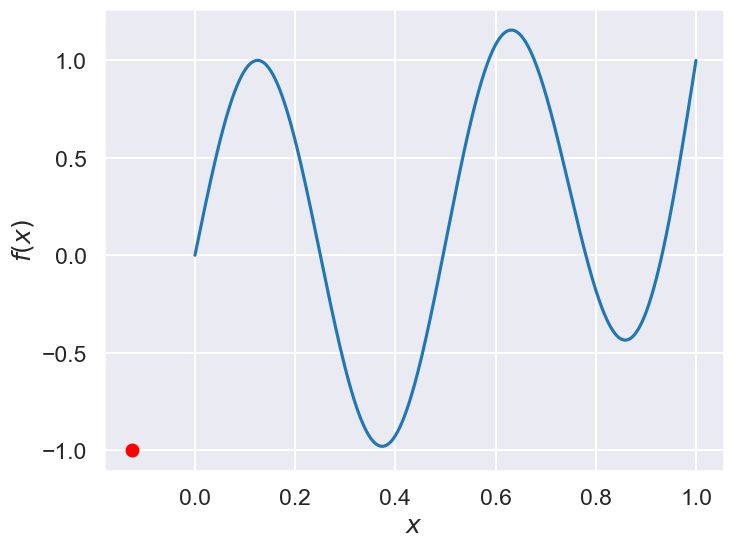

In [7]:
# Plot the function and the minimum that scipy found
X_domain = np.linspace(xmin,xmax,1000)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(X_domain, Ftrue(X_domain))
ax.plot(result.x[0], result.fun, 'ro')
ax.set(xlabel=r'$x$', ylabel=r'$f(x)$');

In [8]:
# parameter bound(s) 
bounds = [{'name': 'x_1', 'type': 'continuous', 'domain': (xmin,xmax)}]

In [9]:
# We'll consider two choices for the acquisition function, expectived 
#  improvement (EI) and lower confidence bound (LCB)
# my_acquisition= 'EI'
# #my_acquisition= 'LCB'

# # Creates GPyOpt object with the model and aquisition function
# myBopt = SklearnBO(\
#             f=Ftrue,                  # function to optimize   
#             initial_design_numdata=1, # Start with two initial data
#             domain=bounds,            # box-constraints of the problem
#             acquisition=my_acquisition, # Selects acquisition type
#             exact_feval = True) 
my_acquisition = 'EI'   # or 'LCB', 'PI'
myBopt = SklearnBO(
    f=Ftrue,
    domain=bounds,
    acquisition=my_acquisition,
    initial_samples=4,   # ← was initial_design_numdata
    random_state=0
)  # drop exact_feval


In [10]:
# Run the optimization
np.random.seed()   # (123)
max_iter = 1      # evaluation budget (max_iter=1 means one step at a time)
max_time = 60     # time budget 
eps      = 1.e-6  # minimum allowed distance between the last two observations

Now we can use the `myBopt.run` one step at a time (meaning we add one point per iteration), plotting the GP mean (solid black line) and 95% variance (gray line) and the acquisition function in red using `plot_acquisition`.  The maximum of the acquisition function, which will be the choice for $x$ in the next iteration, is marked by a vertical red line. 

**What can you tell about the GP used as a surrogate for $f(x)$?**

Note how the GP is refined (updated) with additional points.

Starting with 4 points
Iteration  0


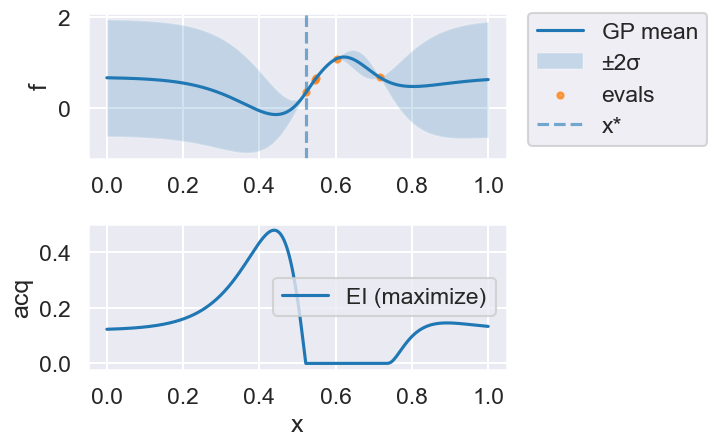

Iteration  1


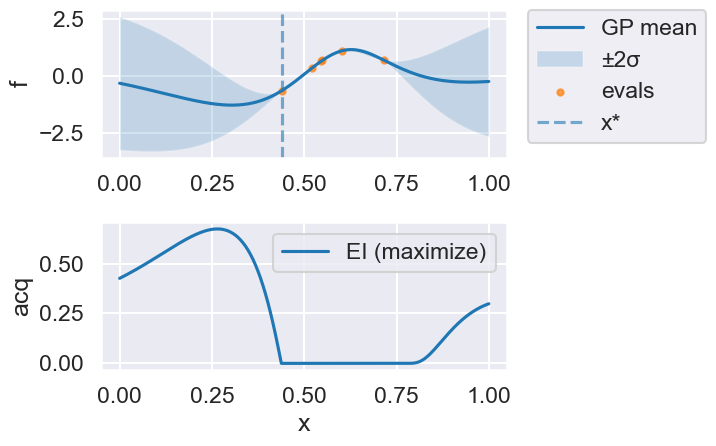

Iteration  2


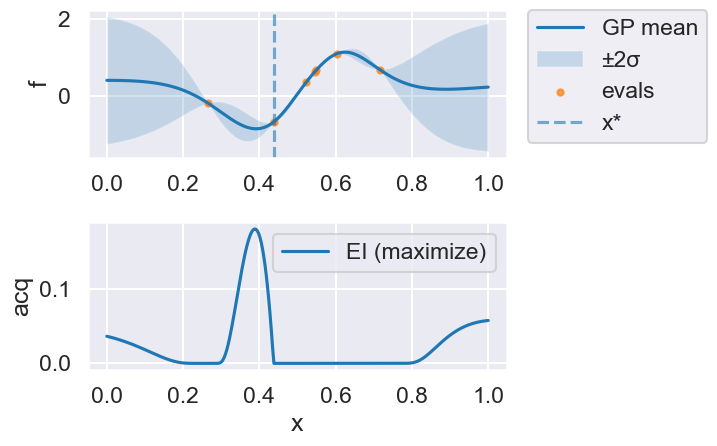

Iteration  3


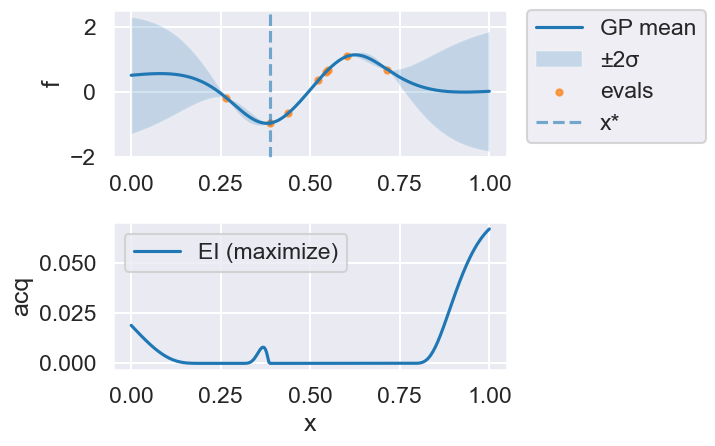

Iteration  4


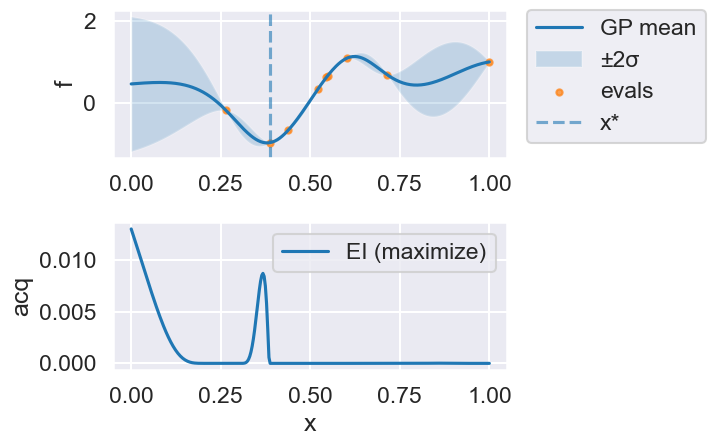

Iteration  5


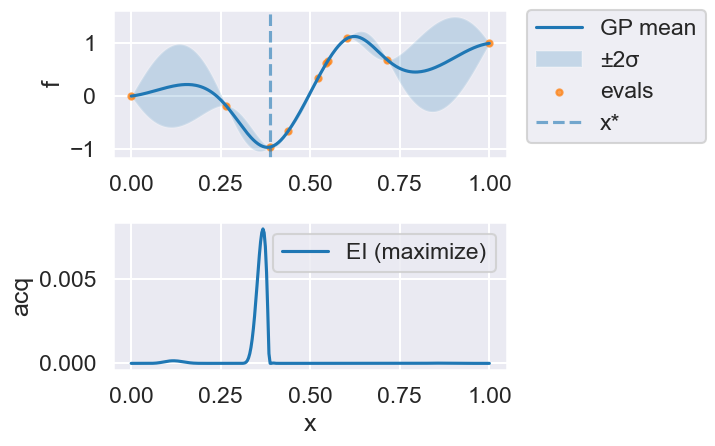

Iteration  6


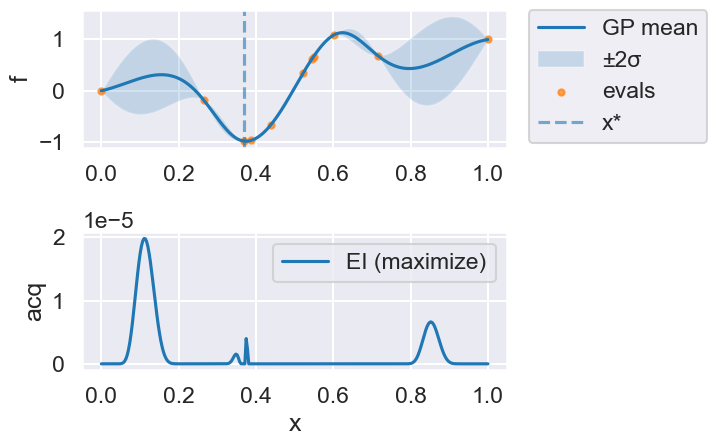

Iteration  7


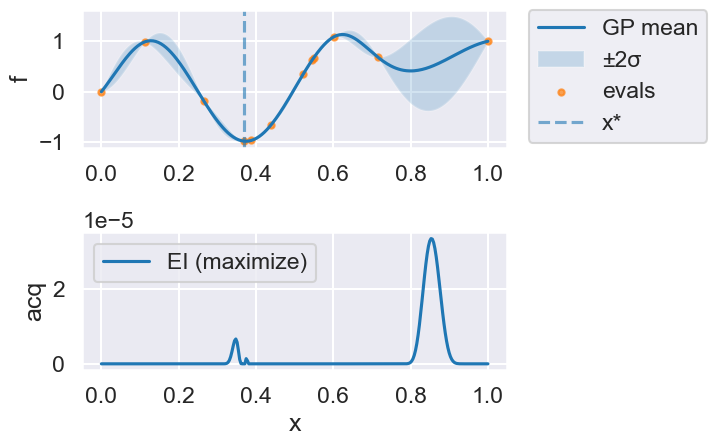

Iteration  8


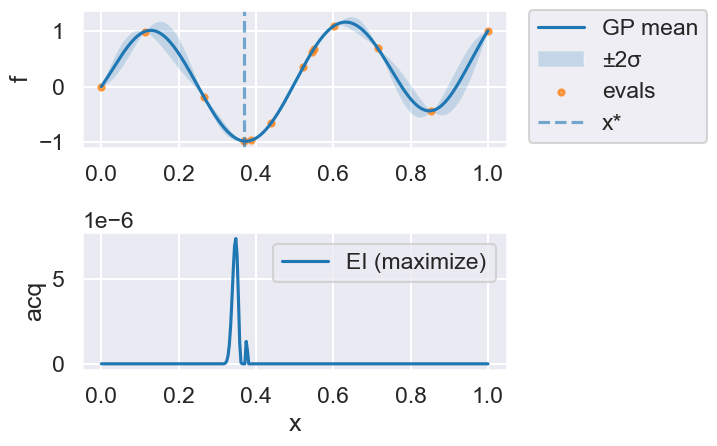

Iteration  9


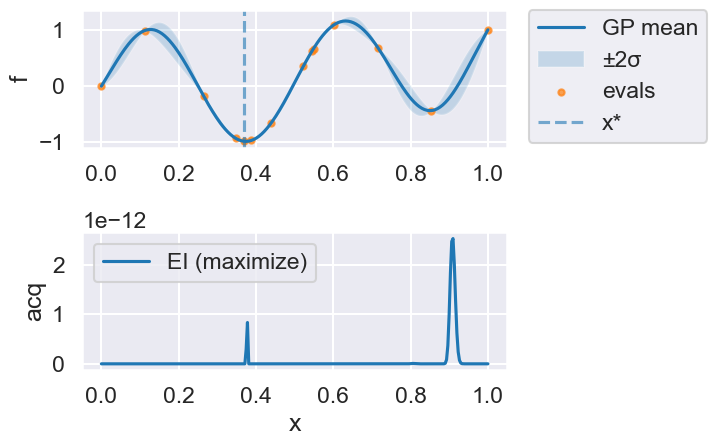

Iteration  10


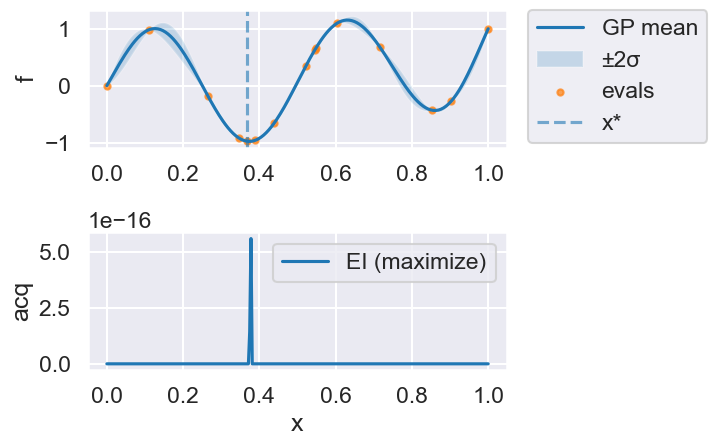

Iteration  11


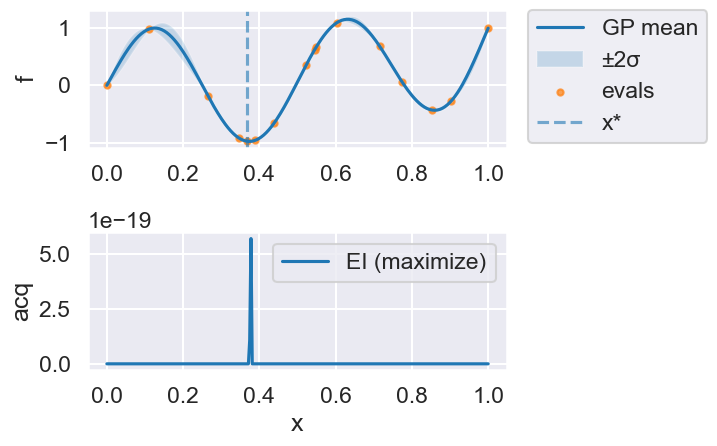

Iteration  12


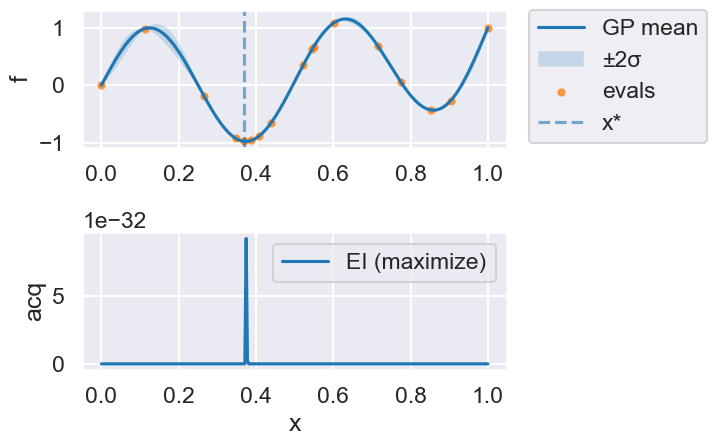

Iteration  13


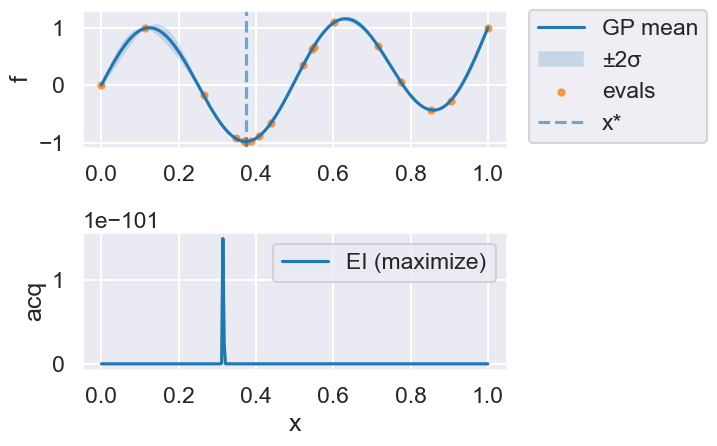

Iteration  14


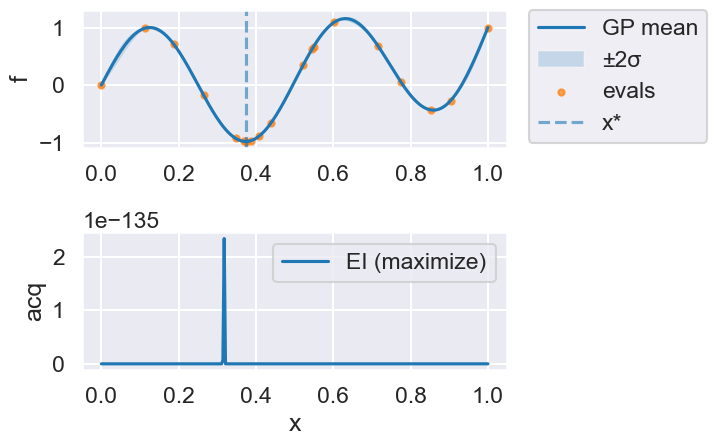

In [11]:
# run for num_iter iterations
num_iter = 15
print('Starting with 4 points')
for i in range(num_iter):
    print("Iteration ", i)
    myBopt.run(max_iter=1, tol=0.0, verbose=False)  # run one BO step per loop
    myBopt.plot_acquisition()
    

In [12]:
print("len(history) =", len(myBopt.history))
print("X shape =", getattr(myBopt, "X", None).shape if hasattr(myBopt, "X") else None)
print("Y shape =", getattr(myBopt, "Y", None).shape if hasattr(myBopt, "Y") else None)


len(history) = 16
X shape = (19, 1)
Y shape = (19, 1)


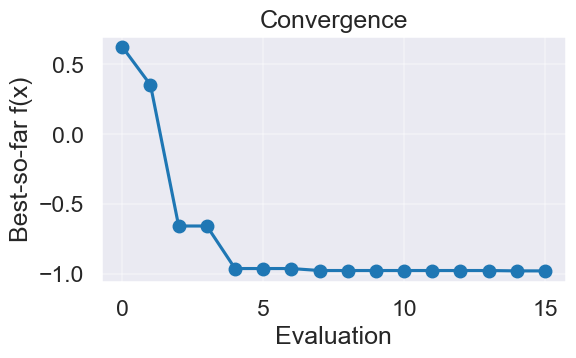

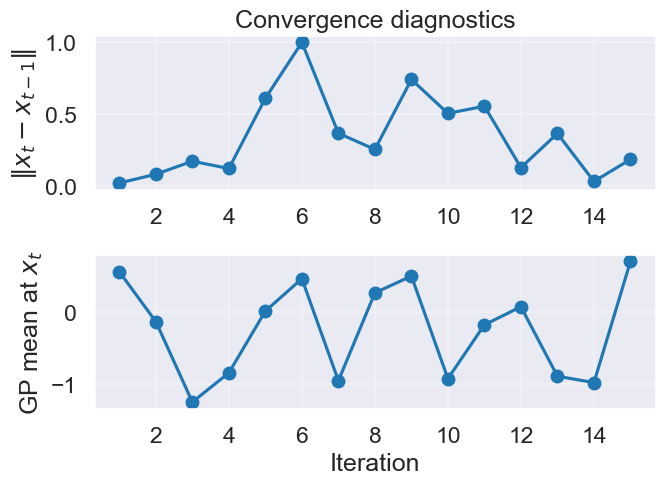

Optimal x value = [0.37381314]
Minimized function value = -0.98036


In [13]:
# From the docstring:
# Makes two plots to evaluate the convergence of the model:
#   plot 1: Iterations vs. distance between consecutive selected x's
#   plot 2: Iterations vs. the mean of the current model in the selected sample.

myBopt.plot_convergence()               # best-so-far f(x)
myBopt.plot_convergence_gpopt_style()   # two-panel style like GPyOpt
print(f'Optimal x value = {myBopt.X_opt}')
print(f'Minimized function value = {myBopt.fx_opt:.5f}')

## Bivariate example (two parameters)

Next, we try a 2-dimensional example. In this case we minimize the Six-hump camel function

$$
f(\theta_1,\theta_2)=\left( 4−2.1 \theta_1^2 + \frac{\theta_1^4}{3}\right)\theta_1^2+\theta_1 \theta_2+\left(−4+4\theta_2^2\right)\theta_2^2,
$$

in $[−3,3]$, $[−2,2]$. This functions has two global minimum, at (0.0898, −0.7126) and (−0.0898, 0.7126), with function value -1.0316. The function is already pre-defined in `GPyOpt`. In this case we generate observations of the function perturbed with white noise of first of sd=0.01 and then sd=0.1.

In [14]:
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

class SixHumpCamel:
    """Drop-in replacement for GPyOpt.objective_examples.experiments2d.sixhumpcamel"""

    bounds = [(-3.0, 3.0), (-2.0, 2.0)]

    def __init__(self, sd: float = 0.0, random_state: int | None = None):
        self.sd = float(sd)
        self.rng = np.random.RandomState(random_state)

    @staticmethod
    def _sixhump(xy: np.ndarray) -> np.ndarray:
        xy = np.asarray(xy, dtype=float)
        x, y = xy[..., 0], xy[..., 1]
        return ((4 - 2.1 * x**2 + (x**4)/3.0) * x**2
                + x * y
                + (-4 + 4 * y**2) * y**2)

    def f(self, X):
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            val = self._sixhump(X)
            if self.sd > 0:
                val = val + self.sd * self.rng.randn()
            return float(np.asarray(val).reshape(-1)[0])
        else:
            vals = self._sixhump(X).reshape(-1)
            if self.sd > 0:
                vals = vals + self.sd * self.rng.randn(*vals.shape)
            return vals

    def plot(self, num=300, kind='contour', vmin=None, vmax=None,
             clip_quantiles=(0.05, 0.95), overlay=None, show_minima=True,
             cmap='viridis'):
        """
        Visualize the six-hump camel function.
    
        Parameters
        ----------
        num : int
            Grid resolution (num x num).
        kind : {'contour','surface'}
            Plot type.
        vmin, vmax : float or None
            Color/height limits. If None, set from data quantiles given by clip_quantiles.
        clip_quantiles : (low, high)
            Quantiles in [0,1] used to auto-limit color scale when vmin/vmax not given.
        overlay : None, ndarray, or object with attribute .X
            If ndarray, interpreted as shape (n,2) sample locations to overlay.
            If object has .X (e.g., your SklearnBO instance), those points are overlaid.
        show_minima : bool
            If True, mark the two global minima with red stars.
        cmap : str
            Matplotlib colormap name.
        """
        import numpy as np
        import matplotlib.pyplot as plt
    
        # Build grid and evaluate
        x1 = np.linspace(self.bounds[0][0], self.bounds[0][1], num)
        x2 = np.linspace(self.bounds[1][0], self.bounds[1][1], num)
        X1, X2 = np.meshgrid(x1, x2)
        X = np.c_[X1.ravel(), X2.ravel()]
        Z = self._sixhump(X).reshape(num, num)
    
        # Auto color limits if not supplied
        if vmin is None or vmax is None:
            lo, hi = np.percentile(Z, [100*clip_quantiles[0], 100*clip_quantiles[1]])
            if vmin is None: vmin = lo
            if vmax is None: vmax = hi
    
        # Resolve overlay points
        overlay_pts = None
        if overlay is not None:
            if isinstance(overlay, np.ndarray):
                overlay_pts = np.asarray(overlay, dtype=float).reshape(-1, 2)
            elif hasattr(overlay, "X"):
                overlay_pts = np.asarray(overlay.X, dtype=float).reshape(-1, 2)

        # Known global minima (for reference/teaching)
        mins = np.array([[0.0898, -0.7126], [-0.0898, 0.7126]])
    
        if kind == 'surface':
            from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
            fig = plt.figure(figsize=(7, 5.5))
            ax = fig.add_subplot(111, projection='3d')
            surf = ax.plot_surface(X1, X2, Z, cmap=cmap, linewidth=0, antialiased=True,
                                   alpha=0.95)
            # keep z-limits aligned with color scaling to emphasize humps
            ax.set_zlim(vmin, vmax)
            fig.colorbar(surf, shrink=0.8, pad=0.1, label='f(x)')
            ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('f(x)')
            ax.set_title('Six-Hump Camel (surface)')
    
            # Overlay samples
            if overlay_pts is not None and overlay_pts.size:
                Zs = self._sixhump(overlay_pts)
                ax.scatter(overlay_pts[:,0], overlay_pts[:,1], Zs, s=30, c='k', depthshade=False, label='samples')
    
            # Overlay minima
            if show_minima:
                Zm = self._sixhump(mins)
                ax.scatter(mins[:,0], mins[:,1], Zm, marker='*', s=140, c='red', label='global minima')
    
            if (overlay_pts is not None and overlay_pts.size) or show_minima:
                ax.legend(loc='upper left')
    
            plt.tight_layout()
            plt.show()
            return
    
        # Default: contour plot
        fig = plt.figure(figsize=(8.6, 5.2))
        cs = plt.contourf(X1, X2, Z, levels=60, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar(cs, label='f(x)')
        # light contour lines to give shape
        plt.contour(X1, X2, Z, levels=12, colors='k', alpha=0.25, linewidths=0.7)

        # Overlay samples
        if overlay_pts is not None and overlay_pts.size:
            plt.scatter(overlay_pts[:,0], overlay_pts[:,1], s=24, c='k', label='samples', alpha=0.9)
    
        # Overlay minima
        if show_minima:
            plt.scatter(mins[:,0], mins[:,1], c='red', marker='*', s=120, label='global minima')
    
        plt.xlabel('x1'); plt.ylabel('x2')
        plt.title('Six-Hump Camel (contour, auto-scaled)')
        if (overlay_pts is not None and overlay_pts.size) or show_minima:
            # put legend outside to avoid obscuring details
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.tight_layout(rect=[0, 0, 0.85, 1])
        else:
            plt.tight_layout()
        plt.show()
    


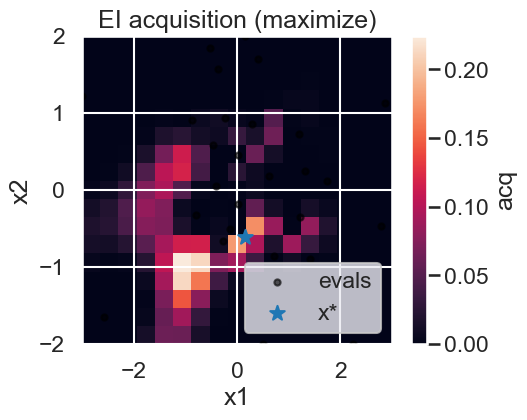

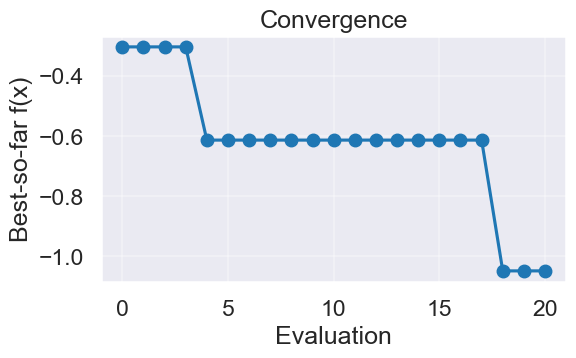

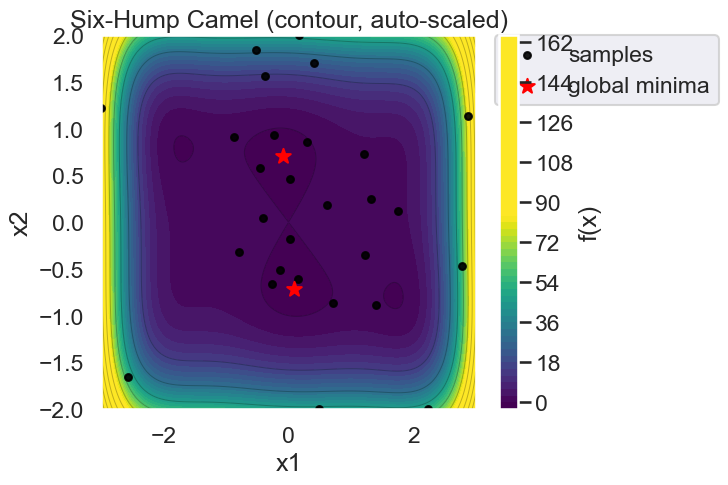

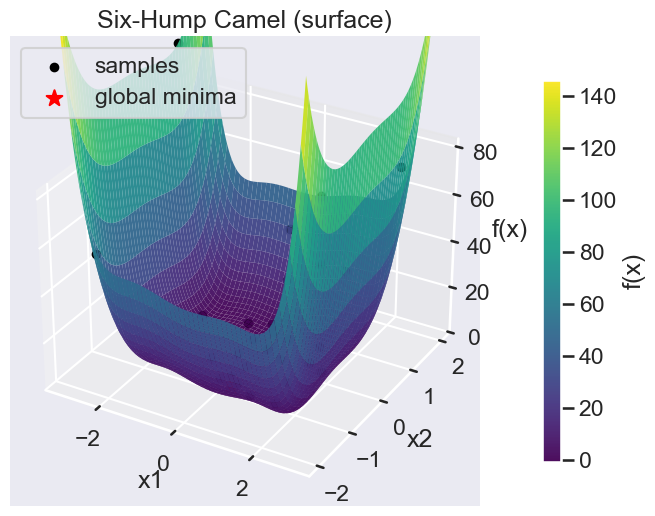

X* = [ 0.14512331 -0.61062049]   f* = -1.0482776249782293


In [15]:
# create the object function (2D example)
f_true = SixHumpCamel(sd=0.0)      # noiseless “true” objective
#f_true.plot()
#f_true.plot(kind='surface', clip_quantiles=(0.05, 0.9))
f_sim  = SixHumpCamel(sd=0.1)      # noisy simulator

bounds = [
    {'name': 'var_1', 'type': 'continuous', 'domain': f_true.bounds[0]},
    {'name': 'var_2', 'type': 'continuous', 'domain': f_true.bounds[1]},
]

# run Bayesian optimization using the explicit sklearn version
myBopt2D = SklearnBO(
    f=f_sim.f,                 # pass the callable
    domain=bounds,
    acquisition='EI',          # or 'LCB', 'PI'
    initial_samples=8,
    random_state=0
)
myBopt2D.run(max_iter=20, tol=0.0, verbose=False)
myBopt2D.plot_acquisition()      # 2D heatmap in our implementation
myBopt2D.plot_convergence()

f_true.plot(overlay=myBopt2D)                      # or overlay=myBopt2D.X
f_true.plot(kind='surface', overlay=myBopt2D.X)

print("X* =", myBopt2D.X_opt, "  f* =", myBopt2D.fx_opt)


### Space-filling sampling

![sampling](https://raw.githubusercontent.com/buqeye/LearningFromData/main/LectureNotes/_images/space_filling_sampling.png)

* Sobol sequence sampling in Python, e.g. with [sobol_seq](https://github.com/naught101/sobol_seq)
* Latin Hypercube Sampling in Python, e.g. with [pyDOE](https://pythonhosted.org/pyDOE/index.html)
* Mersenne-Twister is the core random number generator in Python / numpym

## Some concluding remarks
from the paper [arXiv:1902.00941](https://arxiv.org/abs/1902.00941): 
* **Prior knowledge/belief is everything!** Important to tailor the acquisition function and the GP kernel to the spatial structure of the objective function. Thus, the usefulness of BayesOpt hinges on the arbitrariness and uncertainty of a priori information. Complicated by the fact that we resort to BayesOpt when little is known about the objective function in the first place, since it is computationally expensive to evaluate. 
* In general, BayesOpt will never find a narrow minimum **nor be useful for extracting the exact location of any optimum**. So one might want to use it as the first stage in a hierarchical optimization scheme to identify the interesting regions of parameter space.  One may also want to switch from a more explorative acquisition function in early iterations to more exploitive in later iterations.
* We find that the **acquisition function is more important** than the form of the GP-kernel. 
* BayesOpt would probably benefit from a prior that captures the **large-scale structure of the objective function**.
* **High-dimensional parameter domains** are always challenging (subspace learning, dim reduction).